## Data Read

In [1]:
import pandas as pd
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import os
import os.path
import codecs, json
from timeit import default_timer as timer
from sklearn import preprocessing
from collections import Counter

data = pd.read_csv('data/augmento_input.csv')
data = data.drop(columns=['date'])
data1 = pd.read_csv('data/BTC-USD.csv')
data1 = data1.rename(columns={'Close':'BTC_Price','Volume':'BTC_Volume'})
data2 = data1[['Date','BTC_Price','BTC_Volume']]
dataset = pd.concat([data2, data], axis=1)

## WordCloud

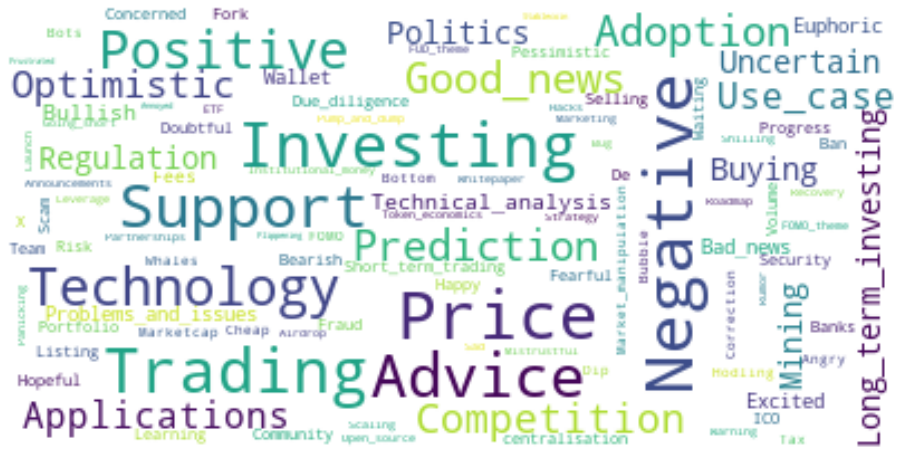

In [2]:
from wordcloud import WordCloud
df_wc = data
df_wc1 = df_wc.sum(axis =0)
#ax = tt.plot.bar()
word_counts = (df_wc1/min(df_wc1)).to_numpy().astype(int)
#print(word_counts)
word_names = df_wc.columns
text= ''
for i in range(len(df_wc1)):
    for j in range(word_counts[i]):
        text += word_names[i]+','
wordcloud = WordCloud(max_font_size=30, background_color="white",collocations=False).generate(text)
fig = plt.figure(figsize = (16,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## K-means

In [3]:
df = dataset.set_index('Date')
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(df)

X = data[:,2:]
y = data[:,0]
y = y.reshape(-1, 1)

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels = kmeans.labels_

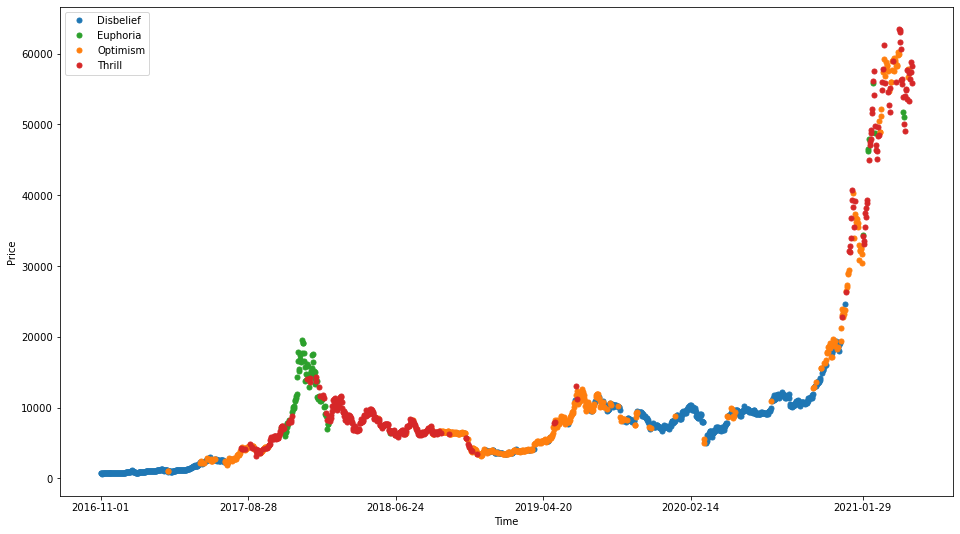

In [5]:
df_new = df.copy()
df_new['Label'] = labels
df_new['ind'] = np.arange(df_new.shape[0])
df_new['Label'].replace({2:'Disbelief',1:'Optimism',3:'Euphoria',0:'Thrill'},inplace=True)
fig = plt.figure(figsize = (16,9))

groups = df_new.groupby('Label')
color = ['C0','C3','C2','C1']
for name, group in groups:
    if name == 'Disbelief':
        plt.plot(group.ind, group.BTC_Price, marker='.', linestyle='', markersize=10, label=name,color='C0')
    elif name == 'Optimism':
        plt.plot(group.ind, group.BTC_Price, marker='.', linestyle='', markersize=10, label=name,color='C1')
    elif name == 'Thrill':
        plt.plot(group.ind, group.BTC_Price, marker='.', linestyle='', markersize=10, label=name,color='C3')
    elif name == 'Euphoria':
        plt.plot(group.ind, group.BTC_Price, marker='.', linestyle='', markersize=10, label=name,color='C2')

xx = [0,300,600,900,1200,1550]
plt.xticks(xx,df_new.index[xx])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.rcParams.update({'font.size': 20})

In [6]:
import codecs, json
with open('kmeans_labels.json','w') as f:
 	json.dump(labels.tolist(),f)

## LASSO feature selection

In [7]:
'''Market data + Sentiment data'''
data = pd.read_csv('data/augmento_input.csv')
data = data.drop(columns=['date'])
data1 = pd.read_csv('data/BTC-USD.csv')
data1 = data1.rename(columns={'Close':'BTC_Price','Volume':'BTC_Volume'})
data1 = data1.drop(columns=['Adj Close'])
data2 = data1[['Date','BTC_Price','BTC_Volume']]
dataset = pd.concat([data2, data], axis=1)
data1 = data1.drop(columns=['BTC_Price','Date'])
dataset = pd.concat([dataset, data1.iloc[:, 0:3]], axis=1)
df = dataset.set_index('Date')

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(df)
X = data[:,1:]
y = data[:,0]
y = y.reshape(-1, 1)
tscv = TimeSeriesSplit(n_splits=10)
model = Lasso()
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
mae_lasso_error_all = []
for i in grid['alpha']:
    mae_temp = []
    for train_index, test_index in tscv.split(X):
        if i==0:
            reg = LinearRegression().fit(X[train_index],y[train_index])
            y_pred_linear = reg.predict(X[test_index])
            mae_temp.append(mean_absolute_error(y[test_index], y_pred_linear))
        else:
            model = Lasso(alpha=i)
            model.fit(X[train_index],y[train_index])
            y_pred_lasso = model.predict(X[test_index])
            mae_temp.append(abs(y[test_index] - y_pred_lasso))
    mae_temp2 = np.mean(np.array(mae_temp))
    mae_lasso_error_all.append(mae_temp2)
val, idx = min((val, idx) for (idx, val) in enumerate(mae_lasso_error_all))
print('best lasso alpha: ' ,grid['alpha'][idx])

best lasso alpha:  0.01


In [33]:
data

array([[0.01486989, 0.05671078, 0.07097592, ..., 0.025     , 0.03829225,
        0.02881844],
       [0.03345725, 0.06994329, 0.07097592, ..., 0.        , 0.05589789,
        0.03398175],
       [0.03097893, 0.05860113, 0.08618504, ..., 0.        , 0.03653169,
        0.03254083],
       ...,
       [0.03469641, 0.34215501, 0.26235741, ..., 0.1       , 0.28565141,
        0.33081172],
       [0.04213135, 0.41398866, 0.22686946, ..., 0.0875    , 0.29929577,
        0.40237752],
       [0.04089219, 0.35727788, 0.21292776, ..., 0.1625    , 0.28829225,
        0.40826129]])

In [9]:
from sklearn.model_selection import RepeatedKFold
from numpy import arange

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.006
Config: {'alpha': 0.0}


/home/wayne/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/home/wayne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/wayne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08540006229808453, tolerance: 0.006335144500277567
  model = cd_fast.enet_coordinate_descent(


## LSTM prediction

In [10]:
import numpy as np
import pandas as pd
import codecs, json
from sklearn import preprocessing

##############################################################################
''' Market data '''
data1 = pd.read_csv('data/BTC-USD.csv')
data1 = data1.rename(columns={'Close':'BTC_Price','Volume':'BTC_Volume'})
data1 = data1.drop(columns=['Adj Close'])
dataset = data1[['Date','BTC_Price','BTC_Volume','Open','High','Low']]
df = dataset.set_index('Date')
# ##############################################################################
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(df)

X = data[:-1,]
y = data[1:,0]
y = y.reshape(-1, 1)


from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import keras
from timeit import default_timer as timer

dataset =  X
size_test = int(dataset.shape[0]/5) # split 60-20-20\

def split_dataset(data, y):
        train_X, test_X = data[0:-size_test], data[-size_test:]
        train_Y, test_Y = y[0:-size_test], y[-size_test:]
        return train_X, test_X,train_Y, test_Y
    
train_X, test_X,train_Y, test_Y = split_dataset(dataset,y)
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
train = hstack((train_X, train_Y))
test = hstack((test_X, test_Y))
n_input = 14


#####################################################################################
#####################################################################################
# LSTM
#####################################################################################
#####################################################################################
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out=1):
        X, y = list(), list()
        for i in range(len(sequences)):
                end_ix = i + n_steps_in
                out_end_ix = end_ix + n_steps_out-1
                if out_end_ix > len(sequences):
                        break
                seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
                X.append(seq_x)
                y.append(seq_y)
        return array(X), array(y)

def build_model(train, n_input):
        n_layer = 256
        train_x, train_y = split_sequences(train[:-size_test], n_input)
        val_x, val_y = split_sequences(train[-size_test:], n_input)
        verbose, epochs, batch_size = 0, 1500, 112
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        # reshape output into [samples, timesteps, features]
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
        # define model
        model = Sequential()
        model.add(LSTM(n_layer*2, activation='relu', input_shape=(n_timesteps,n_features), return_sequences=True))
        model.add(LSTM(n_layer, activation='relu', return_sequences=False))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(n_layer, activation='relu', return_sequences=True))
        model.add(LSTM(n_layer*2, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(n_outputs)))
        model.compile(loss='mse', optimizer='adam')
        es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(val_x, val_y),callbacks=[es_callback],shuffle=False)

        return model

def evaluate_model(train, test, n_input):
        # fit model
        model = build_model(train, n_input)
        # history is a list of weekly data
        history = [x for x in train]
        # walk-forward validation over each week
        predictions = list()
        for i in range(len(test)):
                # get real observation and add to history for predicting the next week
                history.append(test[i, :])
                # predict the week
                yhat_sequence = forecast(model, history, n_input)
                # store the predictions
                predictions.append(yhat_sequence)
        predictions = array(predictions)
        return predictions
    

def forecast(model, history, n_input):
        data = array(history)
        # retrieve last observations for input data
        input_x = data[-n_input:, :-1]
        input_x = input_x.reshape((1, input_x.shape[0],input_x.shape[1]))
        # forecast the next week
        yhat = model.predict(input_x, verbose=0)
        yhat = yhat[0]
        return yhat

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def smape1(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))
    
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

start = timer()
repeats = 10
results_p = pd.DataFrame()
predictions_scores = list()
predictions_list = list()
for i in range(0,repeats):              
        predictions = evaluate_model(train, test, n_input)
        predictions_list.append(predictions)
        mape_pearsonr_p = mape(test[:, -1], predictions[:,0,0])
        print(mape_pearsonr_p)
        predictions_scores.append(mape_pearsonr_p)
results_p['results'] = predictions_scores
print(results_p.describe())
dt = timer() - start
print("Data compute time %f s" % dt)

Epoch 00397: early stopping
6.781652132409291
Epoch 00400: early stopping
7.703513149732998
Epoch 00515: early stopping
6.581806633858593
Epoch 00382: early stopping
9.097293572752456
Epoch 00339: early stopping
4.134377310807977
Epoch 00339: early stopping
8.220617393599824
Epoch 00336: early stopping
6.303997211986322
Epoch 00468: early stopping
8.347407534595437
Epoch 00468: early stopping
5.8963387904091835
Epoch 00385: early stopping
6.2002797103353675
         results
count  10.000000
mean    6.926728
std     1.449969
min     4.134377
25%     6.226209
50%     6.681729
75%     8.091341
max     9.097294
Data compute time 12412.917073 s


## LSTM Sentiment label

In [11]:
import numpy as np
import pandas as pd
import os
import os.path
import codecs, json
from sklearn import preprocessing
from collections import Counter

'''read kmeans labels '''
kmeans_labels = labels

##############################################################################
''' Market data '''
data1 = pd.read_csv('data/BTC-USD.csv')
data1 = data1.rename(columns={'Close':'BTC_Price','Volume':'BTC_Volume'})
data1 = data1.drop(columns=['Adj Close'])
dataset = data1[['Date','BTC_Price','BTC_Volume','Open','High','Low']]
df = dataset.set_index('Date')
# ##############################################################################
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(df)

X = data[:-1,]
y = data[1:,0]
y = y.reshape(-1, 1)


######################################################################################
def split_sequences(sequences, n_steps_in, n_steps_out=1):
        X, y = list(), list()
        for i in range(len(sequences)):
                # find the end of this pattern
                end_ix = i + n_steps_in
                out_end_ix = end_ix + n_steps_out-1
                # check if we are beyond the dataset
                if out_end_ix > len(sequences):
                        break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
                X.append(seq_x)
                y.append(seq_y)
        return np.array(X), np.array(y)
######################################################################################   
data_stack = np.hstack((X,y))
n_input = 14
data_x, data_y = split_sequences(data_stack, n_input)
######################################################################################
''' k labels distribution and k voting labels'''
num_k = 4 ################################
k_labels = kmeans_labels[:-1].reshape(-1,1)
k_stack = np.hstack((k_labels,y))
data_k, data_k_y = split_sequences(k_stack, n_input)

k_labels_final = [] ################################
k_labels_dist =[] ################################
for ii in range(len(data_k)):
    xx = data_k[ii].reshape(-1,).astype(np.int32)
    yy = np.bincount(xx)
    maximum = max(yy)

    max_k = []
    for i in range(len(yy)):
        if yy[i] == maximum:
            max_k.append(i)
    b = []      
    for i in range(len(xx)-1,-1,-1):
           if any(c == xx[i] for c in max_k):
                b = xx[i]
                break
    k_labels_final.append(b)
    #########################
    temp_array = np.zeros(4)
    for j in range(num_k):
        if Counter(xx).get(j) != None:
            temp_array[j] = Counter(xx).get(j)/n_input
    k_labels_dist.append(temp_array)
    
              
######################################################################################
''' k labels for data'''
sentiment0_x = []
sentiment0_y = []
sentiment1_x = []
sentiment1_y = []
sentiment2_x = []
sentiment2_y = []
sentiment3_x = []
sentiment3_y = []
k_labels = k_labels_final######################
for n in range(len(k_labels)):
    i = k_labels[n]
    if i == 0:
        sentiment0_x.append(data_x[n])
        sentiment0_y.append(data_y[n])
    elif i == 1:
        sentiment1_x.append(data_x[n])
        sentiment1_y.append(data_y[n])
    elif i == 2:
        sentiment2_x.append(data_x[n])
        sentiment2_y.append(data_y[n])    
    elif i == 3:
        sentiment3_x.append(data_x[n])
        sentiment3_y.append(data_y[n])

sentiment_x = [sentiment0_x, sentiment1_x, sentiment2_x, sentiment3_x]
sentiment_y = [sentiment0_y, sentiment1_y, sentiment2_y, sentiment3_y]

## Sentiment probability prediction

### TBD